### Introduction

This is my modified version of [Lung segemenation](https://www.kaggle.com/arnavkj95/data-science-bowl-2017/lung-segmentation-and-candidate-points-generation/discussion)

In [19]:
%pylab --no-import-all
%matplotlib inline

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import time


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [14]:
images_path = '/data1/cancer/KAG2017/stage1/'
image_output = '/data1/cancer/KAG2017/stage1_process/'
samples_path = '/data1/cancer/KAG2017/sample_images/'
samples_output = '/data1/cancer/KAG2017/sample_process/'
sample_candidate = '00cba091fa4ad62cc3200a657aeb957e/'
showImages = True

In [3]:
def read_ct_scan(folder_name):
        # Read the slices from the dicom file
        slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]
        
        # Sort the dicom slices in their respective order
        slices.sort(key=lambda x: int(x.InstanceNumber))
        
        # Get the pixel values for all the slices
        slices = np.stack([s.pixel_array for s in slices])
        slices[slices == -2000] = 0
        return slices


In [4]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

### Segmentation of Lungs

After reading the CT Scan, the first step in preprocessing is the segmentation of lung structures because it is obvious that the regions of interests lies inside the lungs. A threshold of 604(-400 HU) is used at all places because it was found in experiments that it works just fine. We segment lung structures from each slice of the CT Scan image and try not to loose the possible region of interests attached to the lung wall.


In [5]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [6]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])


### Nodule Candidate/Region of Interest Generation

After segmenting the lung structures from the CT Scanned images, our task is to find the candidate regions with nodules. It was found in experiments thats all the region of interests have intensity > 604(-400 HU). So, we used to this threshold to filter the regions.


In [7]:
def convertImage(input_path,output_path):
    ct_scan = read_ct_scan(input_path)
    
    segmented_ct_scan = segment_lung_from_ct_scan(ct_scan)
    #if showImages:
    #    plot_ct_scan(ct_scan)
    
    segmented_ct_scan[segmented_ct_scan < 604] = 0
    
    #if showImages:
    #    plot_ct_scan(segmented_ct_scan)
            
    selem = ball(2)
    binary = binary_closing(segmented_ct_scan, selem)

    label_scan = label(binary)

    areas = [r.area for r in regionprops(label_scan)]
    areas.sort()

    for r in regionprops(label_scan):
        max_x, max_y, max_z = 0, 0, 0
        min_x, min_y, min_z = 1000, 1000, 1000

        for c in r.coords:
            max_z = max(c[0], max_z)
            max_y = max(c[1], max_y)
            max_x = max(c[2], max_x)

            min_z = min(c[0], min_z)
            min_y = min(c[1], min_y)
            min_x = min(c[2], min_x)
        if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
            for c in r.coords:
                segmented_ct_scan[c[0], c[1], c[2]] = 0
        else:
            index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))
    save_array(output_path,segmented_ct_scan)
    
convertImage(samples_path + sample_candidate, samples_output + sample_candidate)


After filtering, there are still lot of noise because of blood vessels. Thus we further remove the two largest connected component.


In [8]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


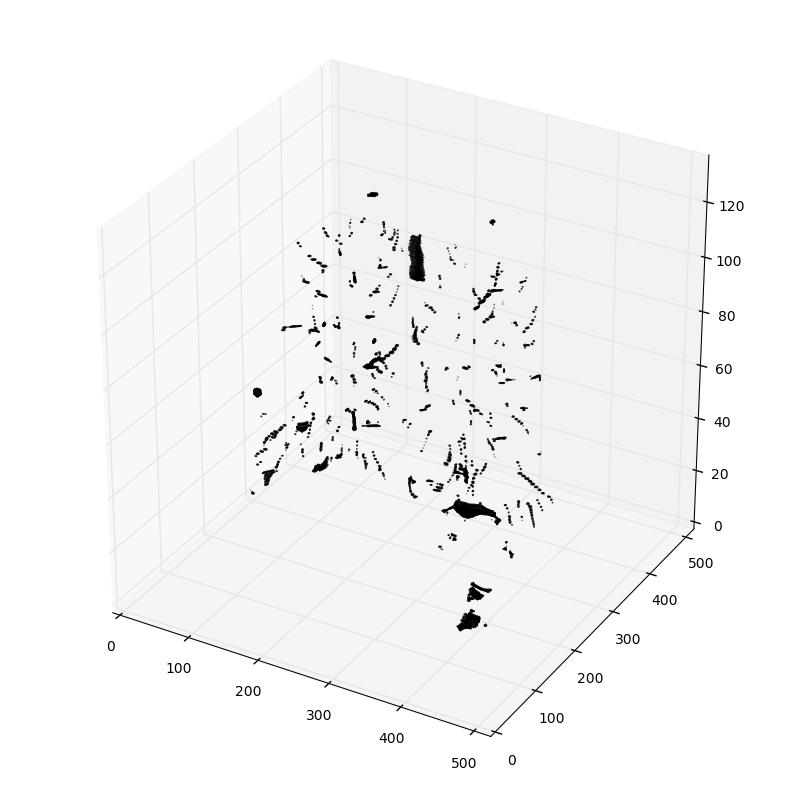

In [9]:
finalImage = load_array(samples_output + sample_candidate)
if showImages:
    plot_3d(finalImage, 604)

### Putting it together for an item
Let's create a single function that does this

In [13]:
%%time
patients = os.listdir(samples_path)
patients.sort()

counter = 0
for x in patients:
    fileName = x +"/"
    convertImage(samples_path + fileName, samples_output + fileName)
    counter += 1
    if (counter % 100 == 0):
        print("completed " + str(counter) + " out of " + str(len(patients)) + ". last is " + fileName)
        
    

CPU times: user 5min 43s, sys: 4.45 s, total: 5min 48s
Wall time: 6min 17s


10:15:43


In [21]:
%%time
patients = os.listdir(images_path)
patients.sort()
counter = 0
index = 0
print (time.strftime("%H:%M:%S"))
for x in patients:
    fileName = x +"/"
    convertImage(images_path + fileName, image_output + fileName)
    counter += 1
    index += 1
    if (counter > 100 ):
        print (time.strftime("%H:%M:%S"))
        counter = 0 
        print("completed " + str(index) + " out of " + str(len(patients)) + ". last is " + fileName)
        
    

10:19:28
10:50:33
completed 101 out of 1595. last is 11f10c2a0bfd231deeec98d69e4d0767/
11:25:10
completed 202 out of 1595. last is 245fe0c86269602b0dab44c345b0b412/
11:57:59
completed 303 out of 1595. last is 327c4e9f365aec05222e253d1a80a1d4/
12:29:50
completed 404 out of 1595. last is 43933b4021d93dd64854f318656c7d1e/
13:03:10
completed 505 out of 1595. last is 55baceb599dc8aefe4b13c131d0531df/
13:36:24
completed 606 out of 1595. last is 6541df84fd779ba6513a530c128f4e9b/
14:10:35
completed 707 out of 1595. last is 74b3ef4c2125d636980a19754702dbb9/
14:45:57
completed 808 out of 1595. last is 8369f716ca2d51c934e7f6d44cb156e9/
15:17:13
completed 909 out of 1595. last is 934bc93ae41ee1d98c7c44d483327f8d/
15:53:29
completed 1010 out of 1595. last is a4fa7dd73e3017b97ac6674a10fac216/
16:25:05
completed 1111 out of 1595. last is b4d5b618fdf3a5a1bcfb325a3715e99e/
16:58:31
completed 1212 out of 1595. last is c2af7c1d6159ae152a79f32d88c33ab2/
17:31:15
completed 1313 out of 1595. last is d2ec8f0